In [ ]:
# # load
# import zipfile
# with zipfile.ZipFile("dl_project/data.zip", 'r') as zip_ref:
#     zip_ref.extractall("dl_project")

## EDA

In [ ]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [2]:
train_data_dir = "/nfs/home/bcw5373/dl_project/master/train"
val_data_dir = "/nfs/home/bcw5373/dl_project/master/valid"
test_data_dir = "/nfs/home/bcw5373/dl_project/master/test"

In [3]:
def generate_data_paths(data_dir):
    filepaths = []
    labels = []
    valid_extensions = (".jpg", ".jpeg", ".png")  # Ensure only image files are considered

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):  # Skip non-directory files
            continue
        
        for file in os.listdir(folder_path):
            if file.lower().endswith(valid_extensions):  # Check for valid images
                filepaths.append(os.path.join(folder_path, file))  # Correct file path storage
                labels.append(folder)  # Assign correct label

    return filepaths, labels

In [4]:
def create_df(filepaths, labels):
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df

In [5]:
filepaths_train, labels_train = generate_data_paths(train_data_dir)
filepaths_val, labels_val = generate_data_paths(val_data_dir)
filepaths_test, labels_test = generate_data_paths(test_data_dir)

In [6]:
df_train = create_df(filepaths_train, labels_train)
df_val = create_df(filepaths_val, labels_val)
df_test = create_df(filepaths_test, labels_test)

In [7]:
df_train['labels'].value_counts()

labels
Other    250
happy    250
Angry    250
Sad      250
Name: count, dtype: int64

In [27]:
df_val['labels'].value_counts()

labels
happy    11
Sad      10
Angry     9
Other     6
Name: count, dtype: int64

In [28]:
df_test['labels'].value_counts()

labels
happy    11
Sad      11
Angry    10
Other     6
Name: count, dtype: int64

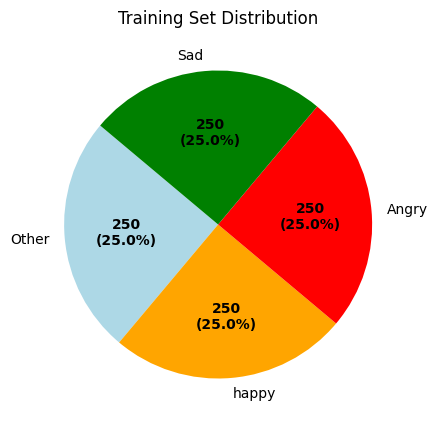

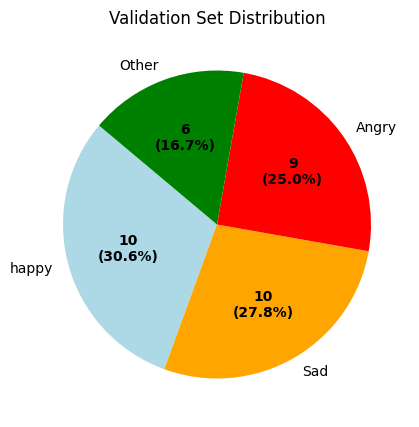

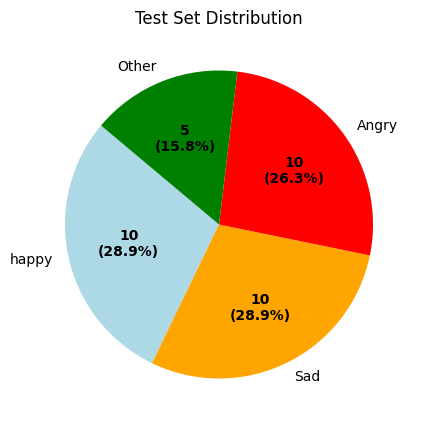

In [37]:
import matplotlib.pyplot as plt
def plot_pie_chart_with_numbers(data, title):
    plt.figure(figsize=(5, 5))
    wedges, texts, autotexts = plt.pie(
        data.values,
        labels=data.index,
        autopct=lambda p: f'{int(p * sum(data.values) / 100)}\n({p:.1f}%)',
        startangle=140,
        colors=['lightblue', 'orange', 'red', 'green']
    )
    plt.setp(autotexts, size=10, weight="bold")
    plt.title(title)
    plt.show()
# Extract actual counts from DataFrames
plot_pie_chart_with_numbers(df_train['labels'].value_counts(), "Training Set Distribution")
plot_pie_chart_with_numbers(df_val['labels'].value_counts(), "Validation Set Distribution")
plot_pie_chart_with_numbers(df_test['labels'].value_counts(), "Test Set Distribution")

## Inspect iamges

In [7]:
import random
import matplotlib.pyplot as plt
from PIL import Image
def display_random_images(filepaths, labels, num_images=6):
    """ Randomly selects and displays images from the dataset """
    if len(filepaths) < num_images:
        num_images = len(filepaths)
    indices = random.sample(range(len(filepaths)), num_images)
    selected_paths = [filepaths[i] for i in indices]
    selected_labels = [labels[i] for i in indices]
    plt.figure(figsize=(12, 6))
    for i, (path, label) in enumerate(zip(selected_paths, selected_labels)):
        try:
            img = Image.open(path)
            plt.subplot(2, num_images // 2 , i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(label)
        except Exception as e:
            print(f"Error opening {path}: {e}")
    plt.show()

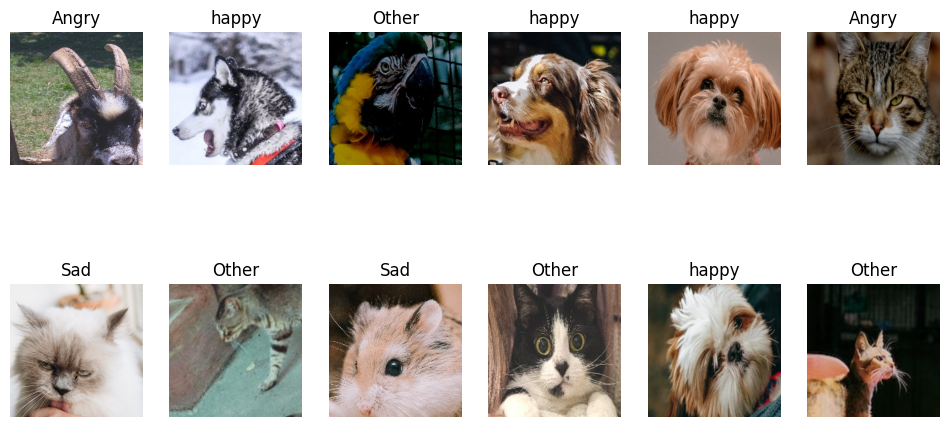

In [8]:
display_random_images(filepaths_train, labels_train, num_images=12)

## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def efficientnet_preprocess(img):
    return img                      
datagen = ImageDataGenerator(
    rotation_range=40, 
    rescale=1./255,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=[0.8, 1.2], 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

)
train_generator = datagen.flow_from_dataframe(df_train, x_col="filepaths", y_col="labels",
                                              target_size=(224, 224), batch_size=64, class_mode='categorical')
val_generator = datagen.flow_from_dataframe(df_val, x_col="filepaths", y_col="labels",
                                            target_size=(224, 224), batch_size=64, class_mode='categorical')

2025-03-14 00:41:44.867008: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 00:41:47.437169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741912908.248902 3946405 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741912908.600715 3946405 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 00:41:50.390523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 1000 validated image filenames belonging to 4 classes.
Found 36 validated image filenames belonging to 4 classes.


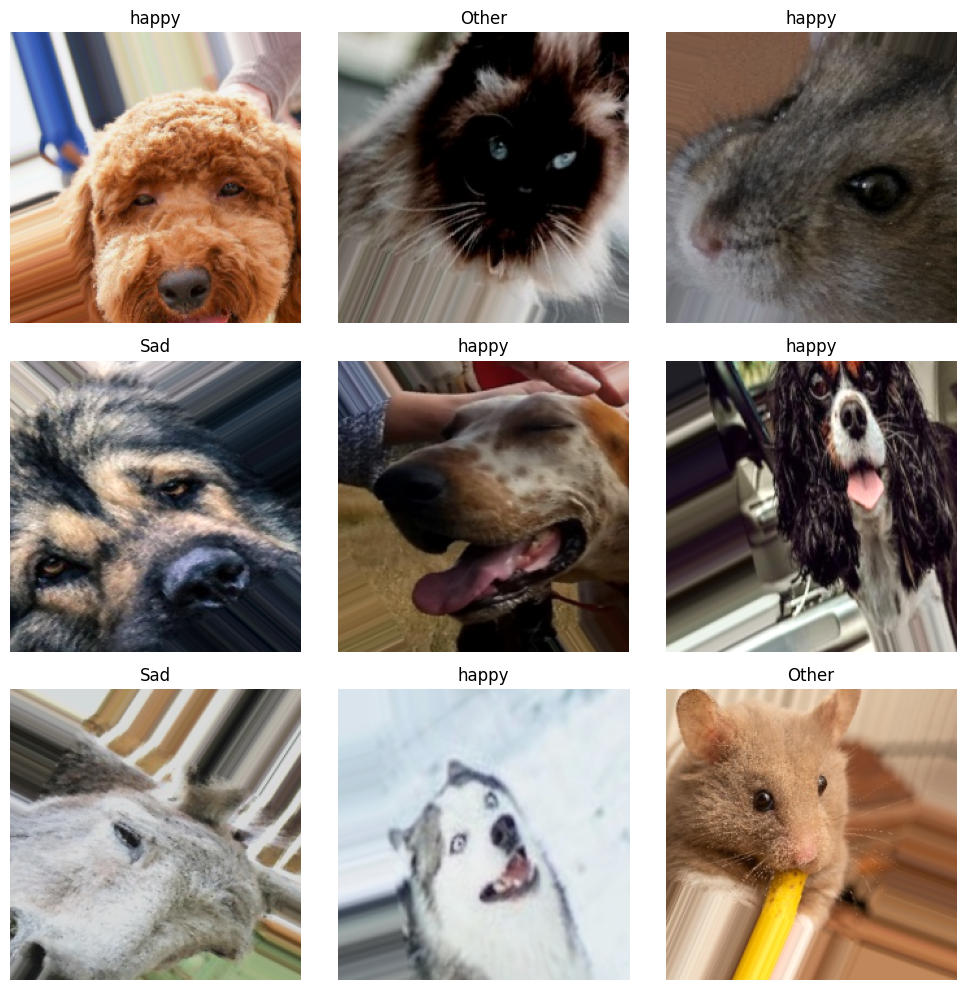

In [12]:
import numpy as np
# Get a batch of augmented images and labels
batch = next(train_generator)
images, labels = batch

# Get class labels from generator
class_labels = list(train_generator.class_indices.keys())

# Set number of images to display
num_images = min(9, len(images))  # Display up to 9 images

# Create a figure
plt.figure(figsize=(10, 10))

for i in range(num_images):
    img = images[i]
    label = labels[i]
    
    # Convert image back to 0-255 range if necessary
    img = img * 255 if np.max(img) <= 1 else img
    
    # Decode label
    label_name = class_labels[np.argmax(label)]

    # Plot image
    plt.subplot(3, 3, i+1)  # 3x3 grid
    plt.imshow(img.astype("uint8"))
    plt.axis("off")
    plt.title(label_name, fontsize=12)

plt.tight_layout()
plt.show()